*****
# Intel® Scalable Dataframe Compiler
*****

### A compiler-based framework for big data in Python  
Intel® Scalable Dataframe Compiler (Intel® SDC) scales analytics/ML codes in Python to bare-metal cluster/cloud performance automatically. It compiles a subset of Python (Pandas/Numpy) to efficient parallel binaries with MPI, requiring only minimal code changes
*****

## Installing

*Installing Binary Packages (conda)*  
`conda install -c intel -c intel/label/test sdc`

SDC advances numba in two dimensions:

1. Support for pandas dataframes and operations  
2. Scaling out to a cluster using MPI

## Machine Learning Problem Statement

The notebook below has been made to demonstrate sdc and daal4py in a data science context. It applies a Cycling Dataset from a social fitness network, and attempts to create a linear regression model from the 5 features collected for telemetry to predict the user's Power output in the absence of a power meter  

In [1]:
import numba

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


## Load and Prepare the data

In [4]:
@numba.jit
def read_from_parquet():
    filename = 'cycling_dataset.pq'
    df = pd.read_parquet(filename)
    return df

In [5]:
df = read_from_parquet()
print(df.shape)

(1000000, 9)


In [4]:
df.head()

,altitude,cadence,distance,hr,latitude,longitude,power,speed,time
0,185.800003,51,3.46,81,30.313309,-97.732711,45,3.459,2016-10-20 22:01:26
1,185.800003,68,7.17,82,30.313277,-97.732715,0,3.710,2016-10-20 22:01:27
2,186.399994,38,11.04,82,30.313243,-97.732717,42,3.874,2016-10-20 22:01:28
3,186.800003,38,15.18,83,30.313212,-97.732720,5,4.135,2016-10-20 22:01:29
4,186.600006,38,19.43,83,30.313172,-97.732723,1,4.250,2016-10-20 22:01:30


## Performance of dataset loading from parquet

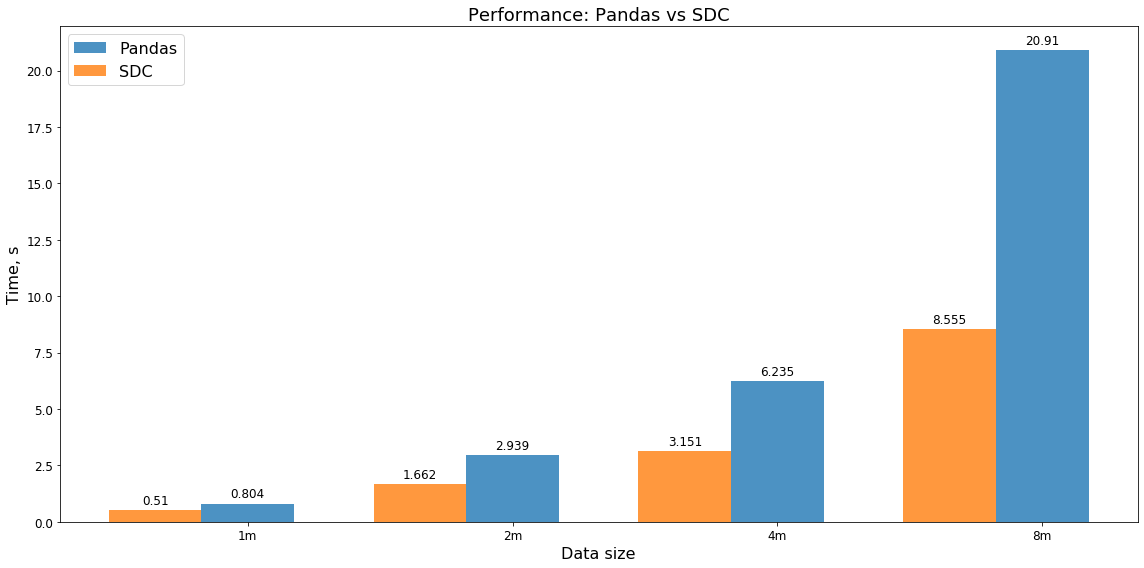

In [2]:
from plotting import Plotter

pl = Plotter()
pl.plot_performance()

In [5]:
@numba.jit
def read_from_csv():
    filename = 'cycling_dataset_2.csv'
    # Currrently we need to provide column names and their types
    names = ['altitude', 'cadence', 'distance', 'hr', 'latitude', 'longitude', 'power', 'speed', 'time']
    dtypes = {
        'altitude': np.float64,
        'cadence': np.float64,
        'distance': np.float64,
        'hr': np.float64,
        'latitude': np.float64,
        'longitude': np.float64,
        'power': np.float64,
        'speed': np.float64,
        'time': str
    }
    df = pd.read_csv(filename, names=names, dtype=dtypes, skiprows=1)
    return df

In [6]:
df = read_from_csv()
df.head()

,altitude,cadence,distance,hr,latitude,longitude,power,speed,time
0,1.0,1.0,185.800003,68.0,7.170000,82.0,30.313277,-97.732715,0
1,2.0,2.0,186.399994,38.0,11.040000,82.0,30.313243,-97.732717,42
2,3.0,3.0,186.800003,38.0,15.180000,83.0,30.313212,-97.732720,5
3,4.0,4.0,186.600006,38.0,19.430000,83.0,30.313172,-97.732723,1
4,5.0,5.0,186.600006,0.0,23.860001,84.0,30.313130,-97.732724,0


**Try it with MPI: run on 4 processes**  
`%save -f runme.py ??
!mpirun -n 4 python ./runme.py`

## Performance of dataset loading from csv: MPI parallelization

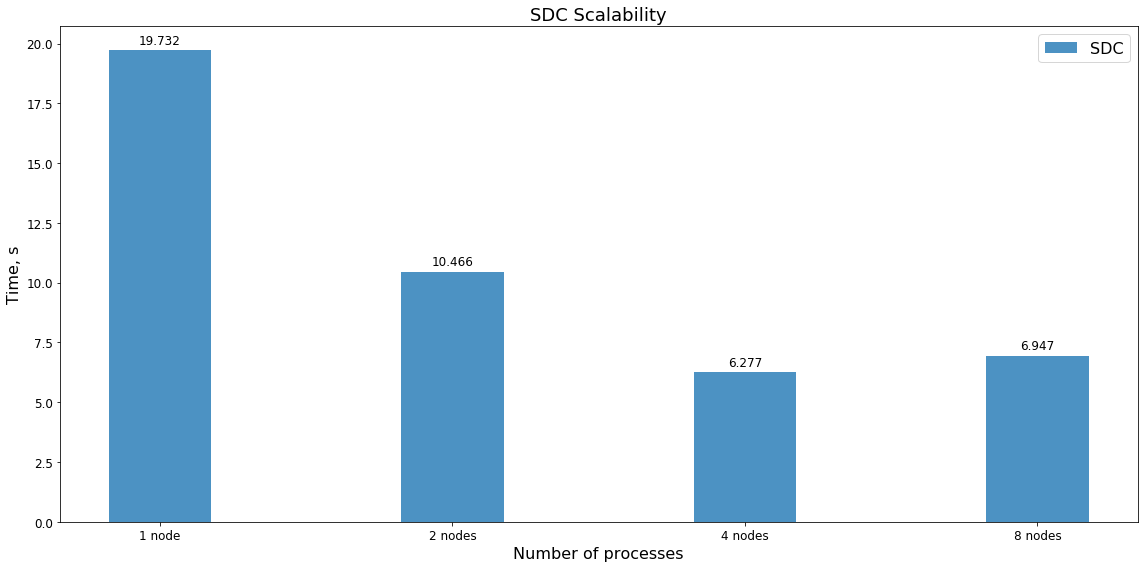

In [3]:
from plotting import Plotter

pl = Plotter('read_csv')
pl.plot_performance()

## Performance of dataframe.describe()

In [28]:
@numba.jit
def data_describe(df):
    # Drop not numerical values from dataframe
    df = df[['altitude', 'cadence', 'cadence', 'distance', 'hr', 'latitude', 'longitude', 'power', 'speed']]
    result = df.describe()
    return result

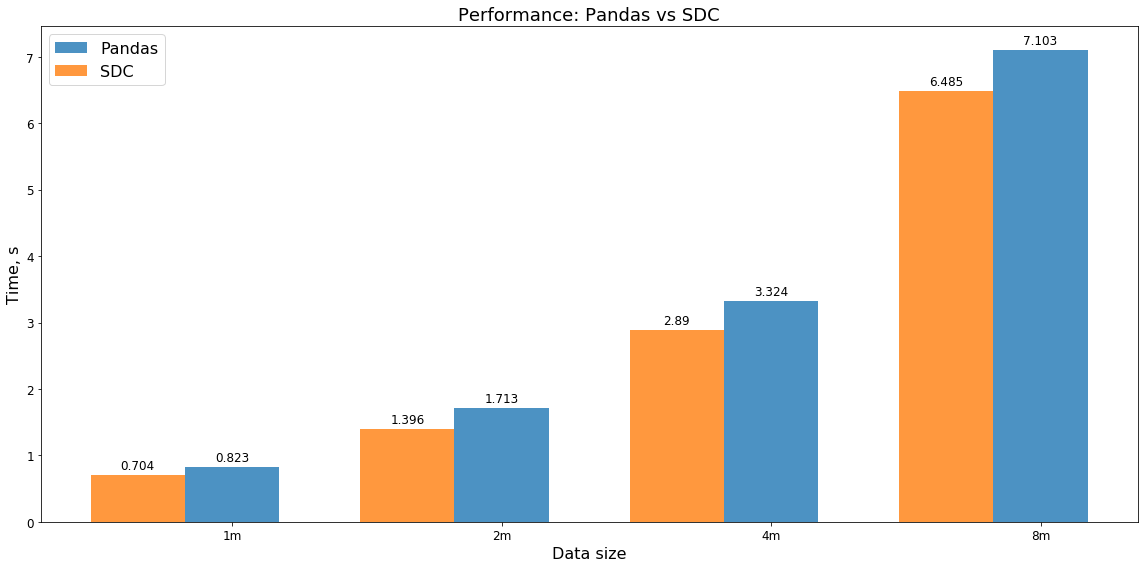

In [4]:
from performance import Plotter

pl = Plotter('describe')
pl.plot_performance()

In [20]:
def groupby_operation(df):
    start = time.time()
    grp = df.groupby('power')
    mean = grp['speed'].mean()
    end = time.time() - start
    return mean, end

In [21]:
sdc_groupby = numba.jit(groupby_operation)
_, t = groupby_operation(df)
_, sdc_t = sdc_groupby(df)

print("TIME python: ", t)
print("TIME SDC: ", sdc_t)

TIME python:  0.05549812316894531
TIME SDC:  0.10742287183529697


## Split the data

In [29]:
def data_split(df):
    start = time.time()
    # Remove entries where power==0
    train = df.drop('time', axis=1)
    train = df[df.power!=0]
    # Reduce the dataset, create X.  We drop the target, and other non-essential features
    reduced_train = train.drop(['time','power','latitude','longitude'], axis=1)
    # Get the target, create Y as an 2d array of float64
    target = train.power.values.reshape(len(train),1).astype(np.float64)
    end = time.time() - start
    
    return reduced_train, target, end

In [30]:
sdc_split = numba.jit(data_split)
train, target, t = data_split(df)
sdc_train, sdc_target, sdc_t = sdc_split(df)

print("TIME python: ", t)
print("TIME SDC: ", sdc_t)

TIME python:  0.8920345306396484
TIME SDC:  0.6088883920165244


## Train the model

After the data was previously processed it can be passed to the ML model input.  
The following code trains a model to predict the power output.

In [31]:
import daal4py as d4p

In [32]:
# Create a linear regression algorithm object
d4p_lm = d4p.linear_regression_training(interceptFlag=True)
# Train the model
lm_trained = d4p_lm.compute(sdc_train.values, sdc_target)

In [33]:
print("Model has this number of features: ", lm_trained.model.NumberOfFeatures)

Model has this number of features:  5


## Predict

In [37]:
def predict(model):
    test_set = pd.read_parquet('cycling_test_dataset.pq')
    test_set = test_set[test_set.power!=0]
    subset = test_set.drop(['time','power','latitude','longitude'], axis=1)
    # create our prediction algorithm object
    lm_predictor = d4p.linear_regression_prediction()
    # Now run prediction. The arguments use the independent data and the trained model from above as the parameters.
    result = lm_predictor.compute(subset.values, model)
    
    return result

In [38]:
pred_result = predict(lm_trained.model)

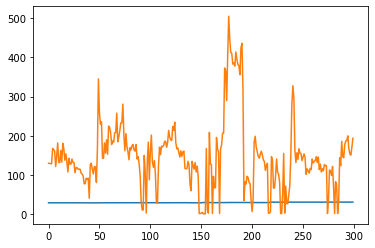

In [39]:
test_set = pd.read_parquet('cycling_test_dataset.pq')
test_set = test_set[test_set.power!=0]
plt.plot(pred_result.prediction[0:300])
plt.plot(test_set.power.values[0:300])
plt.show()